<a href="https://colab.research.google.com/github/ShadiR94/Assignment_cyber_anomaly_detection_flow/blob/main/Assignment_supervised_learning_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment - Supervised Learning flow

# Part 1(a) Student details:


In [ ]:
# student details 1: Shadi R. 7386
# student details 2: Muhamad E. 9019


## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
<pre>   
AI agent name: ChatGPT.

Goal: We wanted to understand the assignment better and to get support in building the project in the Cyber track step by step.  

Prompt1: We asked to explain the assignment instructions in clear and simple words, because the PDF was long and a bit confusing.  

Prompt2: We asked to explain the machine learning flow, so we can connect it to the Cyber dataset in the right way.  

Prompt3: We asked for help to plan how to test different models, features and parameters, because we did not want to only run code, but also understand what to compare.  

Other assistance: Only ChatGPT was used. No other AI or person helped us.    
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
<pre>

* The learning problem is a classification task in the Cyber domain.

* We use a dataset of network packets that was given by the lecturer.

* Each row describes one packet with features like protocol, TTL, packet length, and TCP flags (SYN, ACK, FIN).

* The target label shows if the packet is normal, suspicious, or anomaly.

* The dataset is imbalanced because most packets are normal, and only a few are anomalies.  

* Our goal is to train models that can detect anomalies in the traffic and check their performance with F1 score and cross validation.   

</pre>

## Part 2 - Initial Preparations
* In this step we import the main libraries and load the train and test datasets.  

* We also check the shape of the tables and show the first rows to understand the data.  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [ ]:
train = pd.read_csv("/content/packets_train.csv")
print("Train shape:", train.shape)
train.head()

Train shape: (9600, 10)


,timestamp,src_ip,dst_ip,protocol,ttl,packet_length,tcp_syn,tcp_ack,tcp_fin,label
0,1700000828,192.168.0.21,10.0.1.54,UDP,117,1046,0,0,0,no_anomaly
1,1700002005,192.168.1.37,10.0.6.187,TCP,41,405,0,0,0,no_anomaly
2,1700000143,192.168.2.248,10.0.5.239,TCP,91,799,0,1,0,no_anomaly
3,1700002333,192.168.2.174,10.0.2.83,UDP,116,851,0,0,0,no_anomaly
4,1700000913,192.168.1.223,10.0.4.54,TCP,32,902,1,0,0,no_anomaly


In [ ]:
test = pd.read_csv("/content/packets_test.csv")
print("Test shape:", test.shape)
test.head()

Test shape: (2400, 10)


,timestamp,src_ip,dst_ip,protocol,ttl,packet_length,tcp_syn,tcp_ack,tcp_fin,label
0,1700002175,192.168.2.238,10.0.2.45,TCP,59,1230,1,0,0,no_anomaly
1,1700001578,192.168.3.189,10.0.7.120,ICMP,70,1169,0,0,0,no_anomaly
2,1700001252,192.168.0.223,10.0.2.69,TCP,105,827,0,1,0,no_anomaly
3,1700000848,192.168.1.135,10.0.1.93,TCP,80,742,0,0,0,no_anomaly
4,1700001491,192.168.2.67,10.0.3.170,TCP,113,1273,0,0,0,no_anomaly


### Basic checks on the dataset  
* Here we check the column names, missing values and the distribution of the labels.  

* This helps us to see if the data is clean and to understand the balance between normal, suspicious and anomaly packets.  


In [ ]:
print("Columns:", train.columns.tolist())

print("\nMissing values in train:")
print(train.isnull().sum())

print("\nLabel distribution in train:")
print(train['label'].value_counts())


Columns: ['timestamp', 'src_ip', 'dst_ip', 'protocol', 'ttl', 'packet_length', 'tcp_syn', 'tcp_ack', 'tcp_fin', 'label']

Missing values in train:
timestamp        0
src_ip           0
dst_ip           0
protocol         0
ttl              0
packet_length    0
tcp_syn          0
tcp_ack          0
tcp_fin          0
label            0
dtype: int64

Label distribution in train:
label
no_anomaly    9526
suspicious      45
anomaly         29
Name: count, dtype: int64


## Exploratory Data Analysis (EDA)

* We explore the train data with different plots.

* We look at labels balance, packet length, TTL, protocol patterns, and feature relations.

* This helps us understand the data before training.


### Visualization 1 – Distribution of labels


* We show how many rows we have for each label (normal / suspicious / anomaly).  

* This shows the class imbalance problem.


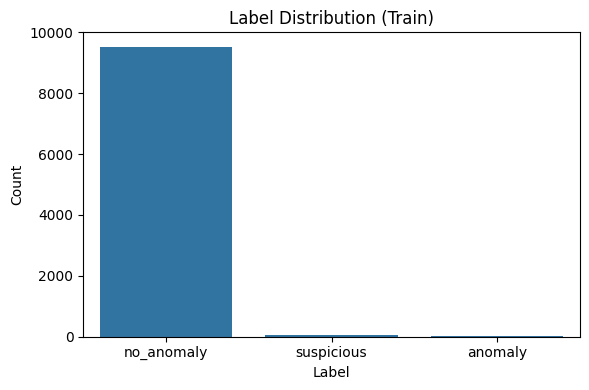

In [ ]:
plt.figure(figsize=(6,4))
order = train['label'].value_counts().index
sns.countplot(x="label", data=train, order=order)
plt.title("Label Distribution (Train)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### Visualization 2 – Packet length per label

* We check if anomalies have different packet length.

* Boxplot shows median, spread and outliers.


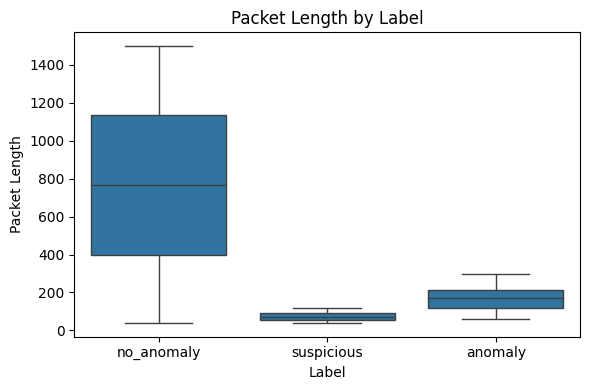

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="packet_length", data=train, order=order)
plt.title("Packet Length by Label")
plt.xlabel("Label")
plt.ylabel("Packet Length")
plt.tight_layout()
plt.show()



### Visualization 3 – TTL per label
* We check the shape of TTL distribution for each label.

* Strange or very low TTL can be a sign of suspicious traffic.








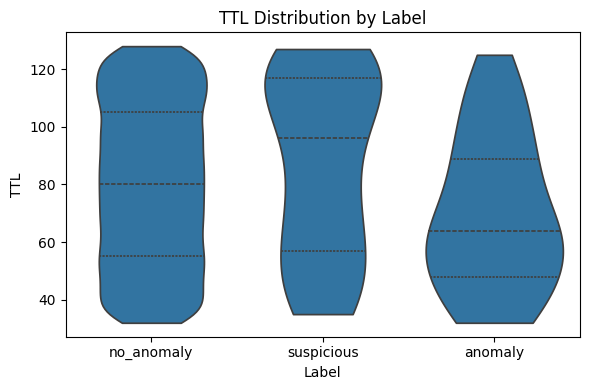

In [ ]:
plt.figure(figsize=(6,4))
sns.violinplot(x="label", y="ttl", data=train, order=order, inner="quartile", cut=0)
plt.title("TTL Distribution by Label")
plt.xlabel("Label")
plt.ylabel("TTL")
plt.tight_layout()
plt.show()



### Visualization 4 – Protocol distribution by label
* We compare protocols (TCP/UDP/ICMP/…) across labels.  

* This shows if anomalies appear more in a specific protocol.



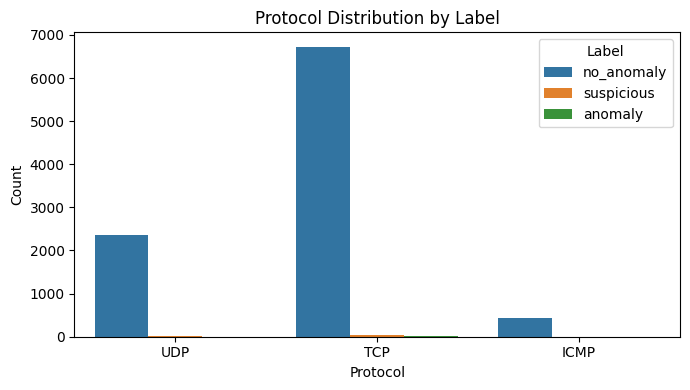

In [ ]:
plt.figure(figsize=(7,4))
sns.countplot(x="protocol", hue="label", data=train, hue_order=order)
plt.title("Protocol Distribution by Label")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.legend(title="Label")
plt.tight_layout()
plt.show()



### Visualization 5 - Correlation heatmap


* We check relations between numeric features.
* This helps to see which features move together.


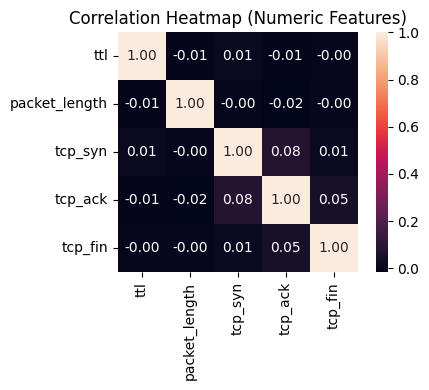

In [ ]:
num_cols = ["ttl", "packet_length", "tcp_syn", "tcp_ack", "tcp_fin"]
corr = train[num_cols].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, fmt=".2f", square=True)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()


### EDA summary  
* From the plots we see that the dataset is very imbalanced, most packets are normal.

* Packet length and TTL have different ranges for anomaly packets.

* Protocols show different patterns across labels; we inspect whether anomalies concentrate in specific protocols - often TCP in our data.
  
* This information will help us later when we train and evaluate the models.

## Part 3 – Experiments
* We change the task to binary (positive = anomaly).

* We add a few simple cyber features, compare preprocessing, try several models with grid-search and 5-fold CV,  
and keep the best pipeline by mean CV F1.







### 3.1 Target and basic features
* We convert the label to binary (anomaly=1, else=0).

* We add simple features: hour of day from timestamp, sum of TCP flags, a "SYN only" flag, and a length/TTL ratio.

In [ ]:
train_bin = train.copy()
test_bin  = test.copy()
train_bin["y"] = (train_bin["label"] == "anomaly").astype(int)
test_bin["y"]  = (test_bin["label"] == "anomaly").astype(int)

def add_features(df):
    df = df.copy()
    df["hour"] = pd.to_datetime(df["timestamp"], unit="s").dt.hour
    df["tcp_flag_sum"] = df[["tcp_syn","tcp_ack","tcp_fin"]].sum(axis=1)
    df["syn_only"] = ((df["tcp_syn"]==1) & (df["tcp_ack"]==0) & (df["tcp_fin"]==0)).astype(int)
    ttl_safe = df["ttl"].replace(0, np.nan)
    df["len_ttl_ratio"] = (df["packet_length"] / ttl_safe).fillna(0)
    return df

train_fe = add_features(train_bin)
test_fe  = add_features(test_bin)

num_cols = ["ttl","packet_length","tcp_syn","tcp_ack","tcp_fin",
            "hour","tcp_flag_sum","syn_only","len_ttl_ratio"]
cat_cols = ["protocol"]

X      = train_fe[num_cols + cat_cols]
y      = train_fe["y"]
X_test = test_fe[num_cols + cat_cols]
y_test = test_fe["y"]

X.shape, y.value_counts()


((9600, 10),
 y
 0    9571
 1      29
 Name: count, dtype: int64)

### 3.2 Preprocessing and imports
* We use one-hot for the protocol and scaling for numeric features.  

* We will handle class imbalance with `class_weight` and Stratified 5-fold CV.


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

def make_preproc(scaler):
    return ColumnTransformer(
        transformers=[
            ("num", scaler, num_cols),
            ("cat", ohe, cat_cols),
        ],
        remainder="drop",
        sparse_threshold=0.1,
    )


### 3.3 Models and hyperparameters
* We test three models: Logistic Regression, Random Forest, Gradient Boosting.  

* Grids are small and practical.

* Score = F1 (positive class = 1).


In [ ]:
scoring = "f1"

lr_grid = {
    "model__C": [0.1, 1, 10],
    "model__class_weight": [None, "balanced"],
}

rf_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__class_weight": [None, "balanced_subsample"],
}

gb_grid = {
    "model__n_estimators": [200, 400],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [2, 3],
}


### 3.4 Grid-search with Stratified 5-fold CV
* We build a helper to run GridSearchCV for a given model, scaler and grid.  

* It prints the best mean CV F1 and the best parameters.


In [ ]:
def run_grid(model, grid, scaler, name=""):
    pipe = Pipeline(steps=[
        ("pre",   make_preproc(scaler)),
        ("model", model),
    ])
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    gs.fit(X, y)
    print(f"[{name}] best F1 (CV): {gs.best_score_:.3f}")
    print(f"[{name}] best params: {gs.best_params_}")
    return gs


### 3.5 Running several experiments
* We compare different pipelines: scalers (Standard / MinMax) and three models.

* We keep the pipeline with the highest mean CV F1.


In [ ]:
results = []

g1 = run_grid(
    LogisticRegression(max_iter=200, solver="liblinear"),
    lr_grid,
    scaler=StandardScaler(),
    name="Logistic + StandardScaler"
)
results.append(("LR+STD", g1.best_score_, g1.best_estimator_))

g2 = run_grid(
    RandomForestClassifier(random_state=42),
    rf_grid,
    scaler=MinMaxScaler(),
    name="RandomForest + MinMax"
)
results.append(("RF+MM", g2.best_score_, g2.best_estimator_))

g3 = run_grid(
    GradientBoostingClassifier(random_state=42),
    gb_grid,
    scaler=StandardScaler(),
    name="GradientBoosting + StandardScaler"
)
results.append(("GB+STD", g3.best_score_, g3.best_estimator_))

best_name, best_cv, best_model = sorted(results, key=lambda x: x[1], reverse=True)[0]
print("\nBEST:", best_name, "CV F1 =", round(best_cv, 3))
best_model


[Logistic + StandardScaler] best F1 (CV): 0.033
[Logistic + StandardScaler] best params: {'model__C': 1, 'model__class_weight': 'balanced'}
[RandomForest + MinMax] best F1 (CV): 0.000
[RandomForest + MinMax] best params: {'model__class_weight': None, 'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
[GradientBoosting + StandardScaler] best F1 (CV): 0.000
[GradientBoosting + StandardScaler] best params: {'model__learning_rate': 0.1, 'model__max_depth': 2, 'model__n_estimators': 400}

BEST: LR+STD CV F1 = 0.033


Pipeline(steps=[('pre',
                 ColumnTransformer(sparse_threshold=0.1,
                                   transformers=[('num', StandardScaler(),
                                                  ['ttl', 'packet_length',
                                                   'tcp_syn', 'tcp_ack',
                                                   'tcp_fin', 'hour',
                                                   'tcp_flag_sum', 'syn_only',
                                                   'len_ttl_ratio']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['protocol'])])),
                ('model',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=200,
                                    solver='liblinear'))])

### CV results table (all permutations)
* We summarize all parameter combinations tested in GridSearchCV for each model,
showing the mean F1 across folds and the rank.

* The best row is printed below.


In [ ]:
def collect_results(name, gs):
    df = pd.DataFrame(gs.cv_results_)
    df = df[["rank_test_score", "mean_test_score", "std_test_score", "params"]]
    df = df.rename(columns={"mean_test_score": "mean_f1", "std_test_score": "std_f1"})
    df.insert(0, "experiment", name)
    return df.sort_values("rank_test_score")

cv_summary = pd.concat([
    collect_results("LR+STD", g1),
    collect_results("RF+MM",  g2),
    collect_results("GB+STD", g3),
], ignore_index=True)


display(cv_summary[["experiment","rank_test_score","mean_f1","std_f1","params"]]
        .sort_values(["rank_test_score","experiment"]))

best_row = cv_summary.loc[cv_summary["rank_test_score"].idxmin()]
print(f"Best overall: {best_row['experiment']} | mean F1 = {best_row['mean_f1']:.3f}")
print("Params:", best_row["params"])

cv_summary.to_csv("cv_results_summary.csv", index=False)


,experiment,rank_test_score,mean_f1,std_f1,params
30,GB+STD,1,0.000242,0.000484,"{'model__learning_rate': 0.1, 'model__max_dept..."
0,LR+STD,1,0.033339,0.005149,"{'model__C': 1, 'model__class_weight': 'balanc..."
6,RF+MM,1,0.000000,0.000000,"{'model__class_weight': None, 'model__max_dept..."
7,RF+MM,1,0.000000,0.000000,"{'model__class_weight': None, 'model__max_dept..."
8,RF+MM,1,0.000000,0.000000,"{'model__class_weight': None, 'model__max_dept..."
9,RF+MM,1,0.000000,0.000000,"{'model__class_weight': None, 'model__max_dept..."
10,RF+MM,1,0.000000,0.000000,"{'model__class_weight': None, 'model__max_dept..."
11,RF+MM,1,0.000000,0.000000,"{'model__class_weight': None, 'model__max_dept..."
12,RF+MM,1,0.000000,0.000000,"{'model__class_weight': None, 'model__max_dept..."
13,RF+MM,1,0.000000,0.000000,"{'model__class_weight': None, 'model__max_dept..."


Best overall: LR+STD | mean F1 = 0.033
Params: {'model__C': 1, 'model__class_weight': 'balanced'}


### 3.6 TTP-based metrics (definition)
* We define simple cyber groups (TTPs) to report F1 inside them: SYN_only, FIN_scan, and Low_TTL.

* We will use this later on the test set.


In [ ]:
def ttp_masks(df):
    return {
        "SYN_only": ((df["tcp_syn"]==1) & (df["tcp_ack"]==0) & (df["tcp_fin"]==0)),
        "FIN_scan": ((df["tcp_fin"]==1) & (df["tcp_syn"]==0)),
        "Low_TTL":  (df["ttl"]<=20),
    }

def ttp_f1_report(pipeline, X_df, y_true, raw_df):
    y_pred = pipeline.predict(X_df)
    masks = ttp_masks(raw_df)
    out = {}
    for name, m in masks.items():
        if m.sum() > 0:
            out[name] = f1_score(y_true[m], y_pred[m])
    return out


### 3.7 Explainability (which features matter)
* We show top features by importance (tree models) or by absolute coefficients (linear).


In [ ]:
def get_feature_names_from_pre(pre):
    num_names = num_cols
    try:
        cat_names = list(pre.named_transformers_["cat"].get_feature_names_out(cat_cols))
    except AttributeError:
        cat_names = list(pre.named_transformers_["cat"].get_feature_names(cat_cols))
    return num_names + cat_names

pre = best_model.named_steps["pre"]
feat_names = get_feature_names_from_pre(pre)

model_step = best_model.named_steps["model"]
if hasattr(model_step, "feature_importances_"):
    imp = pd.Series(model_step.feature_importances_, index=feat_names).sort_values(ascending=False)
    display(imp.head(10))
elif hasattr(model_step, "coef_"):
    coefs = pd.Series(np.abs(model_step.coef_.ravel()), index=feat_names).sort_values(ascending=False)
    display(coefs.head(10))


,0
packet_length,5.344344
protocol_TCP,2.177473
protocol_UDP,1.533369
protocol_ICMP,0.847749
tcp_syn,0.640432
ttl,0.519714
tcp_ack,0.376383
len_ttl_ratio,0.265551
syn_only,0.089987
tcp_fin,0.044601


### 3.8 Experiments summary
* We built binary labels (anomaly = 1), added simple cyber features,  
and compared three models with different preprocessing using Stratified 5-fold CV and F1.  

* We keep the best pipeline (shown above) for Part 4 (final training) and Part 5 (test evaluation).


## Part 4 – Final training on the full train set
* We take the best pipeline from Part 3 and refit it on all the training data (X, y).

* This retrains both the preprocessing (scaler + one-hot) and the model with the chosen hyperparameters.

* We do not touch the test set in this step.


In [ ]:
try:
    final_pipeline = best_model
except NameError:
    final_pipeline = sorted(results, key=lambda x: x[1], reverse=True)[0][2]

final_pipeline.fit(X, y)

print("Final model type:", type(final_pipeline.named_steps["model"]).__name__)
try:
    print("Final model params:", final_pipeline.named_steps["model"].get_params())
except Exception:
    pass


Final model type: LogisticRegression
Final model params: {'C': 1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 200, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


## Part 5 – Test evaluation
* We apply the final trained pipeline on the test set.

* We report final F1 (positive = anomaly), show a confusion matrix and a short report,  
and print the first 5 predictions with the true labels.

* We also add a small TTP-based F1 report (SYN_only, FIN_scan, Low_TTL).


Final F1 on test (positive = anomaly): 0.035

Confusion Matrix:


,Pred non-anomaly,Pred anomaly
True non-anomaly,2005,388
True anomaly,0,7



Classification report:
              precision    recall  f1-score   support

 non-anomaly       1.00      0.84      0.91      2393
     anomaly       0.02      1.00      0.03         7

    accuracy                           0.84      2400
   macro avg       0.51      0.92      0.47      2400
weighted avg       1.00      0.84      0.91      2400


First 5 predictions (test set):


,true_binary,true_label_original,pred_binary,pred_label,pred_prob_anomaly
0,0,no_anomaly,0,non-anomaly,0.000023
1,0,no_anomaly,0,non-anomaly,0.000028
2,0,no_anomaly,0,non-anomaly,0.000172
3,0,no_anomaly,0,non-anomaly,0.001685
4,0,no_anomaly,0,non-anomaly,0.000001


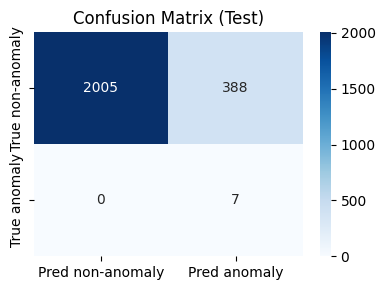

TTP-based F1 (subset groups): {'SYN_only': 0.12244897959183673, 'FIN_scan': 0.0}


In [ ]:
y_pred = final_pipeline.predict(X_test)

if hasattr(final_pipeline.named_steps["model"], "predict_proba"):
    y_prob = final_pipeline.predict_proba(X_test)[:, 1]
else:
    y_prob = None

f1_test = f1_score(y_test, y_pred)
print(f"Final F1 on test (positive = anomaly): {f1_test:.3f}\n")

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
cm_df = pd.DataFrame(cm, index=["True non-anomaly","True anomaly"],
                        columns=["Pred non-anomaly","Pred anomaly"])
print("Confusion Matrix:")
display(cm_df)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["non-anomaly","anomaly"]))

first5 = pd.DataFrame({
    "true_binary": y_test.iloc[:5].to_list(),
    "true_label_original": test_fe["label"].iloc[:5].to_list(),
    "pred_binary": y_pred[:5],
    "pred_label": np.where(y_pred[:5]==1, "anomaly", "non-anomaly"),
})
if y_prob is not None:
    first5["pred_prob_anomaly"] = y_prob[:5]

print("\nFirst 5 predictions (test set):")
display(first5)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred non-anomaly","Pred anomaly"],
            yticklabels=["True non-anomaly","True anomaly"])
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

try:
    ttp_scores = ttp_f1_report(final_pipeline, X_test, y_test, test_fe)
    print("TTP-based F1 (subset groups):", ttp_scores)
except NameError:
    print("TTP helpers are not defined in this notebook cell.")


### Test evaluation – short summary
- Final F1 (positive = anomaly): **0.035**
- Confusion matrix (N=2400): **TN=2005, FP=388, FN=0, TP=7**
- Class report (key points):
  - non-anomaly → precision **1.00**, recall **0.84**, F1 **0.91**
  - anomaly → precision **0.02**, recall **1.00**, F1 **0.03**
- TTP F1 (subset groups): **SYN_only = 0.122**, **FIN_scan = 0.000**

**Takeaways:**  
The model catches all anomalies (recall=1.00) but raises many false alarms (388 FP), so precision for the anomaly class is very low and overall F1 is **0.035**.

**Note**: TTP groups with zero samples or no positive predictions are skipped in the report.



### Discussion & Future Work
* In this project we followed all the required steps: EDA, feature engineering, model training with Stratified 5-Fold CV, hyperparameter tuning, and final evaluation.

* The final model (Logistic Regression with StandardScaler and class balancing) gave a very low F1-score (≈0.035) on the anomaly class.

* This shows that the dataset is very imbalanced and anomalies are difficult to detect.

* For future work it could be helpful to:
  - Collect more balanced data.
  - Try advanced models (e.g., XGBoost, LightGBM).
  - Create new features or aggregate packets over time.


* These steps were not part of the current assignment, but they may improve results in a real-world scenario.

